# Importing libraries and Loading the data

In [7]:
import pandas as pd
import sweetviz as sv
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

In [26]:
import os
import json
import logging
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [123]:
# Correct list to remove
low_quality_cols = ['building_age','ejari_contract_number','registration_date','version_number','version_text','contract_amount','is_freehold','parcel_id','property_id','land_property_id','property_type_ar','property_subtype_ar','property_usage_ar','property_usage_id','project_name_ar','area_ar','area_id','nearest_landmark_ar','nearest_metro_ar','nearest_mall_ar','master_project_en','parking','project_name_en','master_project_ar','req_from','req_to','entry_id','meta_ts','ejari_property_type_id','ejari_property_sub_type_id','transaction_datetime', 'transaction_subtype_id','transaction_number','transaction_type_id','property_usage_id','parcel_id','transaction_size_sqm','property_id','property_type_ar','property_type_id','property_subtype_ar','property_subtype_id','rooms_ar','project_name_ar','area_ar','area_id','nearest_landmark_ar','nearest_metro_ar','nearest_mall_ar','master_project_ar','req_from','req_to','entry_id','meta_ts'] #remove id columns, give logic, add to low quality list here


In [124]:
transactions_final = pd.read_csv('downloads/SB-Case Study Materials/data/snp_dld_2024_transactions.csv')

In [126]:
# Compute the mean of the 'amount' column
mean_amount = transactions_final['amount'].mean()

print(f"Mean of 'amount' column: {mean_amount:.2f}")

Mean of 'amount' column: 3275140.09


In [127]:
# Find the minimum and maximum values in the 'amount' column
min_value = transactions_final['amount'].min()
max_value = transactions_final['amount'].max()

print(f"Minimum value in 'amount': {min_value}")
print(f"Maximum value in 'amount': {max_value}")

Minimum value in 'amount': 100.89
Maximum value in 'amount': 4248836158.5


## Pre-processing and EDA

In [143]:
print("=== Transactions DataFrame ===")
print(transactions_final.head())
print("\nTransactions DataFrame Info:")
print(transactions_final.info())
print("\nTransactions DataFrame Description:")
print(transactions_final.describe())

=== Transactions DataFrame ===
  transaction_number transaction_datetime transaction_type_en  \
0        102-10-2024  2024-01-11 11:05:38               Sales   
1      102-1000-2024  2024-01-08 18:00:51               Sales   
2      102-1001-2024  2024-01-08 18:00:57               Sales   
3      102-1002-2024  2024-01-08 18:01:03               Sales   
4      102-1003-2024  2024-01-08 18:01:07               Sales   

   transaction_type_id   transaction_subtype_en  transaction_subtype_id  \
0                    1  Sell - Pre registration                       0   
1                    1  Sell - Pre registration                       0   
2                    1  Sell - Pre registration                       0   
3                    1  Sell - Pre registration                       0   
4                    1  Sell - Pre registration                       0   

  registration_type_en is_freehold_text property_usage_en  property_usage_id  \
0             Off-Plan        Free Hold       R

/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


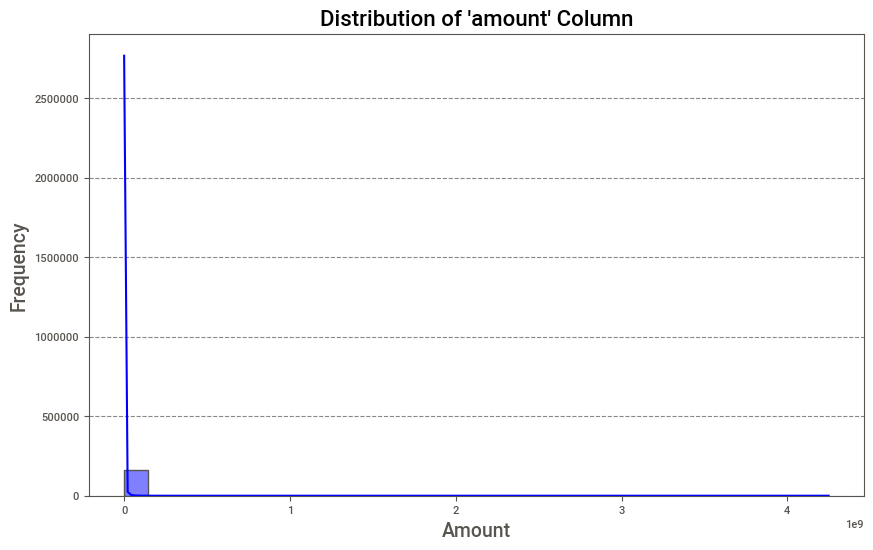

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the 'amount' column
plt.figure(figsize=(10, 6))
sns.histplot(transactions_df_2['amount'], kde=True, bins=30, color='blue')

# Add title and labels
plt.title("Distribution of 'amount' Column", fontsize=16)
plt.xlabel("Amount", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [43]:
import plotly.express as px

# Create a histogram for the 'amount' column
fig = px.histogram(
    transactions_df_2, 
    x='amount', 
    nbins=30,  # Number of bins in the histogram
    title="Distribution of Amount in Transactions",
    labels={"amount": "Amount"},  # Axis label
    template="plotly_white"  # Aesthetic template
)

# Add KDE (density curve) to the plot
fig.update_traces(opacity=0.75)

# Customize layout
fig.update_layout(
    xaxis_title="Amount",
    yaxis_title="Frequency",
    title_font_size=18,
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
)

# Show the plot
fig.show()

### After interacting with the above plot, I looked at the outliers to visualise and understand the distribution of our target better

In [38]:
# Calculate the 1st and 99th percentiles
lower_bound = transactions_df_2['amount'].quantile(0.01)
upper_bound = transactions_df_2['amount'].quantile(0.99)

print(f"1st Percentile (Lower Bound): {lower_bound}")
print(f"99th Percentile (Upper Bound): {upper_bound}")

# Identify outliers
outliers = transactions_df_2[(transactions_df_2['amount'] < lower_bound) | (transactions_df_2['amount'] > upper_bound)]

print(f"Number of Outliers: {outliers.shape[0]}")

# Display the outliers
print(outliers)

1st Percentile (Lower Bound): 280000.0
99th Percentile (Upper Bound): 28163900.000000022
Number of Outliers: 3228
       transaction_number transaction_datetime transaction_type_en  \
124        102-10597-2024  2024-02-21 10:04:14               Sales   
274          102-125-2024  2024-01-11 10:28:19               Sales   
541           102-15-2024  2024-01-02 10:47:30               Sales   
650          102-160-2024  2024-01-04 13:08:17               Sales   
1264        102-2172-2024  2024-01-15 09:40:37               Sales   
...                   ...                  ...                 ...   
162722        9-5468-2024  2024-09-18 12:30:28               Gifts   
162723        9-5469-2024  2024-09-18 12:24:23               Gifts   
162746        9-5494-2024  2024-09-20 08:44:49               Gifts   
162787        9-5541-2024  2024-09-25 13:41:34               Gifts   
162790        9-5544-2024  2024-09-25 09:26:16               Gifts   

        transaction_type_id   transaction_sub

In [44]:
# Calculate all quantiles from 1% to 100% for 'amount' column
quantiles = transactions_df['amount'].quantile([i / 100 for i in range(1, 101)])

# Print the quantile values
print(quantiles)

0.01    2.800000e+05
0.02    3.380282e+05
0.03    3.746940e+05
0.04    4.000000e+05
0.05    4.314524e+05
            ...     
0.96    9.117980e+06
0.97    1.149917e+07
0.98    1.700000e+07
0.99    2.816390e+07
1.00    4.248836e+09
Name: amount, Length: 100, dtype: float64


In [45]:
# Calculate all quantiles from 1% to 100% for 'amount' column
quantiles = transactions_df['amount'].quantile([i / 100 for i in range(1, 101)])

# Expand the display to show all rows and columns
import pandas as pd
pd.set_option('display.max_rows', 101)  # Expand to show all quantiles
pd.set_option('display.float_format', '{:.6e}'.format)  # Use scientific notation

# Print the quantile values
print(quantiles)

1.000000e-02   2.800000e+05
2.000000e-02   3.380282e+05
3.000000e-02   3.746940e+05
4.000000e-02   4.000000e+05
5.000000e-02   4.314524e+05
6.000000e-02   4.600000e+05
7.000000e-02   4.900000e+05
8.000000e-02   5.067588e+05
9.000000e-02   5.300000e+05
1.000000e-01   5.500000e+05
1.100000e-01   5.700000e+05
1.200000e-01   5.900000e+05
1.300000e-01   6.060333e+05
1.400000e-01   6.256881e+05
1.500000e-01   6.460000e+05
1.600000e-01   6.634350e+05
1.700000e-01   6.838552e+05
1.800000e-01   7.000000e+05
1.900000e-01   7.210000e+05
2.000000e-01   7.445900e+05
2.100000e-01   7.580012e+05
2.200000e-01   7.791646e+05
2.300000e-01   8.000000e+05
2.400000e-01   8.183242e+05
2.500000e-01   8.400000e+05
2.600000e-01   8.600000e+05
2.700000e-01   8.850000e+05
2.800000e-01   9.069600e+05
2.900000e-01   9.330000e+05
3.000000e-01   9.556840e+05
3.100000e-01   9.810000e+05
3.200000e-01   1.000000e+06
3.300000e-01   1.014703e+06
3.400000e-01   1.041738e+06
3.500000e-01   1.068480e+06
3.600000e-01   1.096

### After taking a closer look at the distribution of the less frequent values, we can see that there are certain values that may be of interest. For e.g: 4.2B AED could represent a major development

In [144]:
# Filter rows where 'amount' > 50,000,000
high_value_transactions = transactions_final[transactions_final['amount'] > 50000000]

# Display the filtered DataFrame
print(f"Number of transactions with 'amount' > 50,000,000: {high_value_transactions.shape[0]}")
print(high_value_transactions)

Number of transactions with 'amount' > 50,000,000: 738
       transaction_number transaction_datetime transaction_type_en  \
274          102-125-2024  2024-01-11 10:28:19               Sales   
1264        102-2172-2024  2024-01-15 09:40:37               Sales   
1766        102-2640-2024  2024-01-16 18:03:52               Sales   
1819        102-2688-2024  2024-01-16 18:13:25               Sales   
1822        102-2690-2024  2024-01-16 18:13:35               Sales   
...                   ...                  ...                 ...   
162595        9-5222-2024  2024-09-10 07:18:05               Gifts   
162615        9-5243-2024  2024-09-18 10:14:15               Gifts   
162645        9-5278-2024  2024-09-12 14:40:51               Gifts   
162651        9-5284-2024  2024-09-24 09:52:22               Gifts   
162689        9-5377-2024  2024-09-20 10:56:42               Gifts   

        transaction_type_id   transaction_subtype_en  transaction_subtype_id  \
274                     

### Run pip install sweetviz before running the next cell. Thank you and enjoy the viz!

In [145]:
hv_trans_report = sv.analyze(high_value_transactions)
hv_trans_report.show_html("High_Value_Transactions_EDA_Report.html")

                                             |                                                                …

/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/sweetviz/graph.py:33: UserWarning:

Glyph 1605 (\N{ARABIC LETTER MEEM}) missing from current font.

/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/sweetviz/graph.py:33: UserWarning:

Matplotlib currently does not support Arabic natively.

/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/sweetviz/graph.py:33: UserWarning:

Glyph 1576 (\N{ARABIC LETTER BEH}) missing from current font.

/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/sweetviz/graph.py:33: UserWarning:

Glyph 1606 (\N{ARABIC LETTER NOON}) missing from current font.

/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/sweetviz/graph.py:33: UserWarning:

Glyph 1609 (\N{ARABIC LETTER ALEF MAKSURA}) missing from current font.

/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/sweetviz/graph.py:33: UserWarning:

Glyph 1608 (\N{ARABIC LETTER WAW}) missing from current font.

/Users/jaideepballani/anaconda3/lib/

Report High_Value_Transactions_EDA_Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


python(46632) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


### From the visuals, I observed that there are a few amounts that might not make sense. One such amount was 100 AED(too low!)

## Filtering the rows based on infrequent values of amount which could affect our model performance

In [74]:
# Filter rows where 50,000 <= 'amount' <= 50,000,000
final_outliers_filtered_transactions_df = transactions_final[(transactions_final['amount'] >= 50000) & (transactions_final['amount'] <= 50000000)]

# Display the number of rows in the filtered DataFrame
print(f"Number of transactions with 50,000 <= 'amount' <= 50,000,000: {final_outliers_filtered_transactions_df.shape[0]}")

# Display the first few rows of the filtered DataFrame
print(final_outliers_filtered_transactions_df.head())

Number of transactions with 50,000 <= 'amount' <= 50,000,000: 161991
  transaction_number transaction_datetime transaction_type_en  \
0        102-10-2024  2024-01-11 11:05:38               Sales   
1      102-1000-2024  2024-01-08 18:00:51               Sales   
2      102-1001-2024  2024-01-08 18:00:57               Sales   
3      102-1002-2024  2024-01-08 18:01:03               Sales   
4      102-1003-2024  2024-01-08 18:01:07               Sales   

   transaction_type_id   transaction_subtype_en  transaction_subtype_id  \
0                    1  Sell - Pre registration                       0   
1                    1  Sell - Pre registration                       0   
2                    1  Sell - Pre registration                       0   
3                    1  Sell - Pre registration                       0   
4                    1  Sell - Pre registration                       0   

  registration_type_en is_freehold_text property_usage_en  property_usage_id  \
0        

In [142]:
final_outliers_filtered_transactions_df.head()

transaction_type_en   transaction_subtype_en registration_type_en  \
0               Sales  Sell - Pre registration             Off-Plan   
1               Sales  Sell - Pre registration             Off-Plan   
2               Sales  Sell - Pre registration             Off-Plan   
3               Sales  Sell - Pre registration             Off-Plan   
4               Sales  Sell - Pre registration             Off-Plan   

  is_freehold_text property_usage_en       amount  total_buyer  total_seller  \
0        Free Hold       Residential 8.863200e+05            2             1   
1        Free Hold       Residential 1.169025e+06            1             1   
2    Non Free Hold       Residential 1.285588e+06            2             1   
3        Free Hold       Residential 2.636200e+06            1             1   
4        Free Hold       Residential 1.681899e+06            1             1   

   property_size_sqm is_offplan property_type_en property_subtype_en rooms_en  \
0       6.647000e+01          t             Unit                Flat    1 B/R   
1       7.076000e+01          t             Unit                Flat    1 B/R   
2       1.153300e+02          t             Unit                Flat    2 B/R   
3       1.100200e+02          t             Unit                Flat    2 B/R   
4       7.332000e+01          t             Unit                Flat    1 B/R   

                             area_en           nearest_landmark_en  \
0            JUMEIRAH VILLAGE CIRCLE  Sports City Swimming Academy   
1            JUMEIRAH VILLAGE CIRCLE  Sports City Swimming Academy   
2                      SILICON OASIS          IMG World Adventures   
3                DUBAI MARITIME CITY                           NaN   
4  Hadaeq Sheikh Mohammed Bin Rashid                           NaN   

        nearest_metro_en       nearest_mall_en  
0    Dubai Internet City  Mall of the Emirates  
1  Nakheel Metro Station           Marina Mall  
2                    NaN                   NaN  
3                    NaN                   NaN  
4                    NaN                   NaN

### I decided to remove amount values <50,000 AED and >50,000,000 AED

In [4]:
low_quality_cols = ['contract_start_date','contract_end_date','building_age','ejari_contract_number','registration_date','version_number','version_text','contract_amount','is_freehold','parcel_id','property_id','land_property_id','property_type_ar','property_subtype_ar','property_usage_ar','property_usage_id','project_name_ar','area_ar','area_id','nearest_landmark_ar','nearest_metro_ar','nearest_mall_ar','master_project_en','rooms','parking','project_name_en','master_project_ar','req_from','req_to','entry_id','meta_ts','ejari_property_type_id','ejari_property_sub_type_id','transaction_datetime', 'transaction_subtype_id','transaction_number','transaction_type_id','property_usage_id','parcel_id','transaction_size_sqm','property_id','property_type_ar','property_type_id','property_subtype_ar','property_subtype_id','rooms_ar','project_name_ar','area_ar','area_id','nearest_landmark_ar','nearest_metro_ar','nearest_mall_ar','master_project_ar','req_from','req_to','entry_id','meta_ts'] #remove id columns, give logic, add to low quality list here
#rentals_df = rentals_df.drop(columns=[col for col in low_quality_cols if col in rentals_df.columns], errors='ignore')
transactions_df = transactions_df.drop(columns=[col for col in low_quality_cols if col in transactions_df.columns], errors='ignore')

In [128]:
final_outliers_filtered_transactions_df = final_outliers_filtered_transactions_df.drop(columns=[col for col in low_quality_cols if col in final_outliers_filtered_transactions_df.columns], errors='ignore')

### Remember to run pip install sweetviz if you haven't already!

In [155]:
trans_report = sv.analyze(final_outliers_filtered_transactions_df)
trans_report.show_html("Transactions_EDA_Report.html")

                                             |                                                                …

Report Transactions_EDA_Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


python(57853) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [129]:
final_outliers_filtered_transactions_df.columns

Index(['transaction_type_en', 'transaction_subtype_en', 'registration_type_en',
       'is_freehold_text', 'property_usage_en', 'amount', 'total_buyer',
       'total_seller', 'property_size_sqm', 'is_offplan', 'property_type_en',
       'property_subtype_en', 'rooms_en', 'area_en', 'nearest_landmark_en',
       'nearest_metro_en', 'nearest_mall_en'],
      dtype='object')

In [71]:
transactions_final.columns

Index(['transaction_number', 'transaction_datetime', 'transaction_type_en',
       'transaction_type_id', 'transaction_subtype_en',
       'transaction_subtype_id', 'registration_type_en', 'is_freehold_text',
       'property_usage_en', 'property_usage_id', 'amount', 'total_buyer',
       'total_seller', 'transaction_size_sqm', 'property_size_sqm',
       'parcel_id', 'property_id', 'is_offplan', 'is_freehold',
       'property_type_en', 'property_type_ar', 'property_type_id',
       'property_subtype_en', 'property_subtype_ar', 'property_subtype_id',
       'building_age', 'rooms_en', 'rooms_ar', 'parking', 'project_name_en',
       'project_name_ar', 'area_en', 'area_ar', 'area_id',
       'nearest_landmark_en', 'nearest_landmark_ar', 'nearest_metro_en',
       'nearest_metro_ar', 'nearest_mall_en', 'nearest_mall_ar',
       'master_project_en', 'master_project_ar', 'req_from', 'req_to',
       'entry_id', 'meta_ts'],
      dtype='object')

In [130]:
# Perform one-hot encoding on all categorical columns
# Automatically identifies categorical columns
categorical_columns = final_outliers_filtered_transactions_df.select_dtypes(include=['object', 'category']).columns

# Apply one-hot encoding
transactions_encoded = pd.get_dummies(final_outliers_filtered_transactions_df, columns=categorical_columns, drop_first=True)

# Display the first few rows of the encoded DataFrame
print("One-hot encoded DataFrame:")
print(transactions_encoded.head())

One-hot encoded DataFrame:
        amount  total_buyer  total_seller  property_size_sqm  \
0 8.863200e+05            2             1       6.647000e+01   
1 1.169025e+06            1             1       7.076000e+01   
2 1.285588e+06            2             1       1.153300e+02   
3 2.636200e+06            1             1       1.100200e+02   
4 1.681899e+06            1             1       7.332000e+01   

   transaction_type_en_Mortgage  transaction_type_en_Sales  \
0                         False                       True   
1                         False                       True   
2                         False                       True   
3                         False                       True   
4                         False                       True   

   transaction_subtype_en_Delayed Development  \
0                                       False   
1                                       False   
2                                       False   
3                  

In [13]:
def correlation_analysis(df, threshold=0.85):
    """
    Perform correlation analysis to drop highly correlated features.
    """
    print("Running correlation analysis...")
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    df = df.drop(columns=to_drop, errors='ignore')
    print(to_drop)
    print(f"Dropped {len(to_drop)} correlated features.")
    return df, to_drop

In [150]:
correlation_analysis(transactions_encoded, threshold=0.85)

Running correlation analysis...
['transaction_type_en_Sales', 'registration_type_en_Ready', 'is_offplan_t', 'property_subtype_en_Commercial', 'property_subtype_en_Electricity Station', 'property_subtype_en_Flat', 'rooms_en_Office', 'area_en_Al Warsan Third', 'area_en_Hessyan Second', 'nearest_metro_en_Creek Metro Station', 'nearest_metro_en_Financial Centre', 'nearest_metro_en_Ibn Battuta Metro Station', 'nearest_metro_en_Palm Deira Metro Stations', 'nearest_metro_en_UAE Exchange Metro Station']
Dropped 14 correlated features.


(             amount  total_buyer  total_seller  property_size_sqm  \
 0      8.863200e+05            2             1       6.647000e+01   
 1      1.169025e+06            1             1       7.076000e+01   
 2      1.285588e+06            2             1       1.153300e+02   
 3      2.636200e+06            1             1       1.100200e+02   
 4      1.681899e+06            1             1       7.332000e+01   
 ...             ...          ...           ...                ...   
 162801 1.620128e+06            0             0       6.410000e+01   
 162802 2.788751e+06            0             0       1.932380e+03   
 162803 6.750858e+05            0             0       3.062000e+01   
 162804 4.910000e+05            1             1       7.867000e+01   
 162805 8.872820e+05            0             0       8.859000e+01   
 
         transaction_type_en_Mortgage  \
 0                              False   
 1                              False   
 2                              Fal

In [131]:
X = transactions_encoded.drop(columns=["amount"])
y = transactions_encoded["amount"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [132]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(129592, 426) (32399, 426) (129592,) (32399,)


In [22]:
# Train a basic Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_estimators=94, max_depth=10, min_samples_split=4)

print("Training basic Random Forest...")
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Create a DataFrame with actual and predicted values
comparison_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

# Reset the index for clarity (optional)
comparison_df.reset_index(drop=True, inplace=True)

# Display the first few rows
print(comparison_df.head(50))

print("Basic Random Forest Results:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")

Training basic Random Forest...
        Actual     Predicted
0    575900.00  1.076213e+06
1   2506800.00  2.375391e+06
2   4135000.00  3.601923e+06
3   2440000.00  2.894088e+06
4    970000.00  1.076213e+06
5    501840.00  8.636005e+05
6   3829888.00  2.803906e+06
7    558432.00  1.511868e+06
8    565760.00  5.958173e+05
9   1350000.00  1.759081e+06
10  1010000.00  9.949033e+05
11  1946888.00  1.665196e+06
12  3290000.00  3.402845e+06
13  2050000.00  2.821696e+06
14   811888.00  1.061287e+06
15  1652410.00  1.948521e+06
16  1863888.00  1.665196e+06
17  4480002.13  2.770430e+06
18   800000.00  1.076213e+06
19  1107519.89  1.207690e+06
20  4950000.00  3.486069e+06
21  2200000.00  2.084051e+06
22  1334160.00  1.953297e+06
23   525000.00  7.642651e+05
24  3714000.00  3.030472e+06
25  1870000.00  2.738732e+06
26  2000000.00  3.400840e+06
27   790000.00  6.753174e+05
28   601485.00  1.510210e+06
29  4990000.00  4.726882e+06
30  5362227.00  6.410118e+06
31  4286410.00  3.780861e+06
32  1250000

### Both the RMSE and MAE are quite high, with Rsquare decent. This signals weak performance

In [59]:
# Define the parameter grid for Random Forest
param_grid = {
    "n_estimators": [50, 100, 150],         # Number of trees
    "max_depth": [5, 8, 10],              # Maximum depth of trees
    "min_samples_split": [5, 10, 15, 20], # Minimum samples required to split a node          
}
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,                               # 3-fold cross-validation
    scoring="neg_mean_squared_error",   # Use negative MSE for scoring
    n_jobs=-1,                          # Use all CPU cores
    verbose=1                           # Display progress
)

# Train the model with GridSearchCV
print("Training Random Forest with GridSearchCV...")
grid_search.fit(X_train, y_train)

# Best parameters and evaluation
print("Best Parameters:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Evaluation Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")

# Save results to a JSON file
results = {
    "best_params": grid_search.best_params_,
    "rmse": rmse,
    "r2": r2,
    "mae": mae
}

with open("rf_transactions_results.json", "w") as f:
    json.dump(results, f, indent=4)
print("Results saved to rf_transactions_results.json")

# Create a DataFrame for actual vs predicted values
comparison_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
}).reset_index(drop=True)

# Save the comparison file
comparison_df.to_csv("rf_transactions_comparison.csv", index=False)
print("Comparison saved to rf_transactions_comparison.csv")

Training Random Forest with GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/pandas/core/arr

Best Parameters:
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 150}
Evaluation Metrics:
RMSE: 1700727.50
R²: 0.81
MAE: 598807.45
Results saved to rf_transactions_results.json
Comparison saved to rf_transactions_comparison.csv


In [84]:
# Define the parameter grid for Random Forest
param_grid = {
    "n_estimators": [50, 100],         # Number of trees
    "max_depth": [5,10,20,50],              # Maximum depth of trees as features are 426
    "min_samples_split": [5, 10, 15, 20], # Minimum samples required to split a node          
}
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,                               # 3-fold cross-validation
    scoring="neg_mean_squared_error",   # Use negative MSE for scoring
    n_jobs=-1,                          # Use all CPU cores
    verbose=1                           # Display progress
)

# Train the model with GridSearchCV
print("Training Random Forest with GridSearchCV...")
grid_search.fit(X_train, y_train)

# Best parameters and evaluation
print("Best Parameters:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Evaluation Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")

# Save results to a JSON file
results = {
    "best_params": grid_search.best_params_,
    "rmse": rmse,
    "r2": r2,
    "mae": mae
}

with open("rf_transactions_results.json", "w") as f:
    json.dump(results, f, indent=4)
print("Results saved to rf_transactions_results.json")

# Create a DataFrame for actual vs predicted values
comparison_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
}).reset_index(drop=True)

# Save the comparison file
comparison_df.to_csv("rf_transactions_comparison.csv", index=False)
print("Comparison saved to rf_transactions_comparison.csv")

Training Random Forest with GridSearchCV...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/pandas/core/arr

Best Parameters:
{'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 100}
Evaluation Metrics:
RMSE: 1536055.97
R²: 0.85
MAE: 400860.44
Results saved to rf_transactions_results.json
Comparison saved to rf_transactions_comparison.csv


In [141]:
import time
start_time = time.time()
# Define the parameter grid for Random Forest
param_grid = {
    "n_estimators": [100, 150, 200],         # Number of trees
    "max_depth": [10, 25,50, 75],              # Maximum depth of trees as features are 426
    "min_samples_split": [5, 10], # Minimum samples required to split a node          
}
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,                               # 3-fold cross-validation
    scoring="neg_mean_squared_error",   # Use negative MSE for scoring
    n_jobs=-1,                          # Use all CPU cores
    verbose=1                           # Display progress
)

# Train the model with GridSearchCV
print("Training Random Forest with GridSearchCV...")
grid_search.fit(X_train, y_train)

# Best parameters and evaluation
print("Best Parameters:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Evaluation Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")

# Save results to a JSON file
results = {
    "best_params": grid_search.best_params_,
    "rmse": rmse,
    "r2": r2,
    "mae": mae
}

with open("rf_transactions_results.json", "w") as f:
    json.dump(results, f, indent=4)
print("Results saved to rf_transactions_results.json")

# Create a DataFrame for actual vs predicted values
comparison_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
}).reset_index(drop=True)

end_time = time.time()
elapsed = end_time - start_time
print(elapsed)
# Save the comparison file
comparison_df.to_csv("rf_transactions_comparison.csv", index=False)
print("Comparison saved to rf_transactions_comparison.csv")

Training Random Forest with GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


python(32109) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32110) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32111) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32112) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32113) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32114) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32115) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(32116) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas

Best Parameters:
{'max_depth': 75, 'min_samples_split': 5, 'n_estimators': 200}
Evaluation Metrics:
RMSE: 1534598.84
R²: 0.85
MAE: 400034.54
Results saved to rf_transactions_results.json
5957.865416049957
Comparison saved to rf_transactions_comparison.csv


In [87]:
# Define the parameter grid for Random Forest
param_grid = {
    "n_estimators": [100],         # Number of trees
    "max_depth": [50],              # Maximum depth of trees as features are 426
    "min_samples_split": [5],       # Minimum samples required to split a node
     "max_features":[10, 'sqrt', 0.1]                                     # Subset of features used for splitting          
}
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,                               # 3-fold cross-validation
    scoring="neg_mean_squared_error",   # Use negative MSE for scoring
    n_jobs=-1,                          # Use all CPU cores
    verbose=1                           # Display progress
)

# Train the model with GridSearchCV
print("Training Random Forest with GridSearchCV...")
grid_search.fit(X_train, y_train)

# Best parameters and evaluation
print("Best Parameters:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Evaluation Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")

# Save results to a JSON file
results = {
    "best_params": grid_search.best_params_,
    "rmse": rmse,
    "r2": r2,
    "mae": mae
}

with open("rf_transactions_results.json", "w") as f:
    json.dump(results, f, indent=4)
print("Results saved to rf_transactions_results.json")

# Create a DataFrame for actual vs predicted values
comparison_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
}).reset_index(drop=True)

# Save the comparison file
comparison_df.to_csv("rf_transactions_comparison.csv", index=False)
print("Comparison saved to rf_transactions_comparison.csv")

Training Random Forest with GridSearchCV...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


python(40510) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40511) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40512) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40513) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40514) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40515) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40516) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40517) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas

Best Parameters:
{'max_depth': 50, 'max_features': 0.1, 'min_samples_split': 5, 'n_estimators': 100}
Evaluation Metrics:
RMSE: 1504876.62
R²: 0.85
MAE: 405643.51
Results saved to rf_transactions_results.json
Comparison saved to rf_transactions_comparison.csv


### After significant number of iterations using different combinations of parameters and cross validation using Grid Search, the performance improved considerably. MAE reduced to ~10% of the Mean Amount from ~35%

In [88]:
# Define the parameter grid for XGBoost
param_grid = {
    "n_estimators": [100, 200],         # Number of trees
    "max_depth": [5, 10, 12],                # Maximum depth of trees
    "learning_rate": [0.01, 0.05, 0.1],    # Learning rate (eta)
}

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,                               # 3-fold cross-validation
    scoring="neg_mean_squared_error",   # Use negative MSE for scoring
    n_jobs=-1,                          # Use all CPU cores
    verbose=1                           # Display progress
)

# Train the model with GridSearchCV
print("Training XGBoost with GridSearchCV...")
grid_search.fit(X_train, y_train)

# Best parameters and evaluation
print("Best Parameters:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Evaluation Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")

# Create a DataFrame for actual vs predicted
comparison_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
}).reset_index(drop=True)

print(comparison_df.head())

# Save the results to a CSV file (optional)
comparison_df.to_csv("xgboost_predictions_vs_actuals_transactions.csv", index=False)
print("Comparison saved to xgboost_predictions_vs_actuals_transactions.csv")

Training XGBoost with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


python(52262) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(52263) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(52264) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(52265) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(52266) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(52267) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(52268) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(52269) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas

Best Parameters:
{'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 200}
Evaluation Metrics:
RMSE: 1541297.60
R²: 0.85
MAE: 459957.59
        Actual    Predicted
0 3.152670e+06 4.064865e+06
1 5.300000e+05 6.376058e+05
2 1.019000e+06 9.435771e+05
3 9.547500e+05 9.871449e+05
4 2.750888e+06 2.702642e+06
Comparison saved to xgboost_predictions_vs_actuals_transactions.csv


In [90]:
import time 
start_time = time.time()
# Define the parameter grid for XGBoost
param_grid = {
    "n_estimators": [200, 250, 300],         # Number of trees
    "max_depth": [10, 12, 15, 20],                # Maximum depth of trees
    "learning_rate": [0.08, 0.1, 0.12, 0.15],    # Learning rate (eta)
}

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,                               # 3-fold cross-validation
    scoring="neg_mean_squared_error",   # Use negative MSE for scoring
    n_jobs=-1,                          # Use all CPU cores
    verbose=1                           # Display progress
)

# Train the model with GridSearchCV
print("Training XGBoost with GridSearchCV...")
grid_search.fit(X_train, y_train)

# Best parameters and evaluation
print("Best Parameters:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Evaluation Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")

# Create a DataFrame for actual vs predicted
comparison_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
}).reset_index(drop=True)

print(comparison_df.head())

# Save the results to a CSV file (optional)
comparison_df.to_csv("xgboost_predictions_vs_actuals_transactions.csv", index=False)
print("Comparison saved to xgboost_predictions_vs_actuals_transactions.csv")

end_time = time.time()
# Calculate and print the runtime
elapsed_time = end_time - start_time
print(f"Model training completed in {elapsed_time:.2f} seconds.")

Training XGBoost with GridSearchCV...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


python(56976) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56977) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56978) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56979) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56980) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56981) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56982) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56983) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/jaideepballani/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas

Best Parameters:
{'learning_rate': 0.08, 'max_depth': 12, 'n_estimators': 200}
Evaluation Metrics:
RMSE: 1534261.99
R²: 0.85
MAE: 464196.30
        Actual    Predicted
0 3.152670e+06 3.974542e+06
1 5.300000e+05 6.507781e+05
2 1.019000e+06 9.641203e+05
3 9.547500e+05 9.971552e+05
4 2.750888e+06 2.767523e+06
Comparison saved to xgboost_predictions_vs_actuals_transactions.csv
Model training completed in 967.67 seconds.


### As opposed to Rentals, XGBoost performed slightly worse than Random Forest

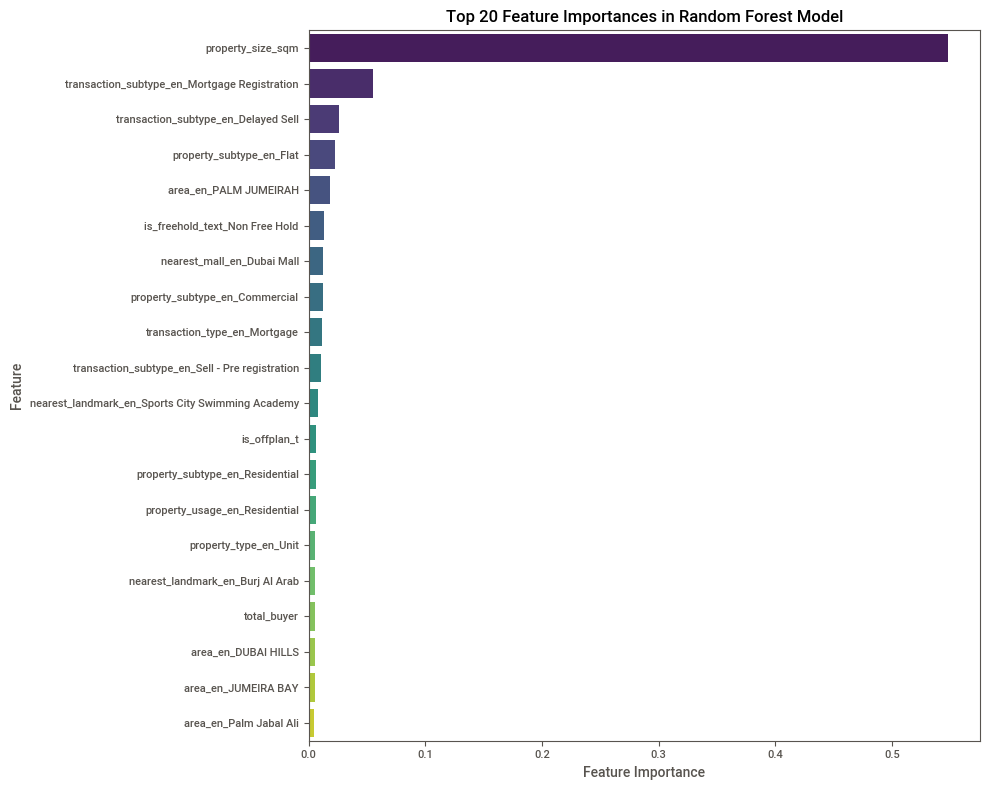

In [153]:
# Extract feature importances
importances = best_model.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})
feature_importances = feature_importances.sort_values(
    by='Importance', ascending=False
)

# Select top 20 features
top_n = 20
top_features = feature_importances.head(top_n)

# Plot using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=top_features,
    palette='viridis'
)
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances in Random Forest Model')
plt.tight_layout()
plt.show()

## In the Random Forest model, property_size_sqm emerges as the most influential feature, highlighting the critical role of property size in determining transaction outcomes, followed by transaction subtypes like Mortgage Registration and Delayed Sell, which reflect the significant impact of financial and transactional specifics on the predictions


## Challenges Faced
### 1. Time Constraints Due to Task Complexity: The intricate nature of the project introduced significant time limitations, making it challenging to complete all tasks within the desired timeframe.

### 2. Memory Limitations on Local Machines: Local memory restrictions impeded the ability to process large datasets efficiently, leading to computational bottlenecks.

### 3. Insufficient Informative and Low-Correlation Features: There was a scarcity of features that were both highly informative and minimally correlated, which affected the overall performance and accuracy of the models.

### 4. Over reliance on a single powerful feature: Property Size importance score was >0.5

## Future Work
### 1. Consider ALE Graphs: Conduct analysis on the features using Accumulated Local Effects (ALE) graphs to gain deeper insights into feature impacts and interactions.

### 2. Augment Dataset with Additional Data: Enhance the dataset by incorporating more comprehensive data sources, such as:

### Historical Data: To identify time series trends and patterns.
### Geolocation Data: To improve spatial visualization and analysis.

### 3. Utilize Cloud Instances for Enhanced Performance: Leverage cloud computing resources to overcome local memory limitations, ensuring better computational performance and scalability for complex tasks.